In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

In [2]:
task = 'attack'

time: 1.42 ms


### Load Annotated Data

In [3]:
d_b, d_r = load_cf_data()

time: 6 s


In [4]:
l_b = plurality(d_b[task].dropna())
l_r = plurality(d_r[task].dropna())

time: 12.4 s


In [5]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

time: 431 ms


### Split into train/dev and test

In [6]:
b_train, b_test = train_test_split(data_b, test_size = 0.2, random_state=0)
r_train, r_test = train_test_split(data_r, test_size = 0.2, random_state=0)
br_train = pd.concat([b_train, r_train])
br_test = pd.concat([b_test, r_test])

time: 37.1 ms


In [7]:
len(b_test.merge(b_train, left_index = True, right_index = True, how = 'inner'))

0

time: 9.18 ms


In [8]:
len(r_test.merge(r_train, left_index = True, right_index = True, how = 'inner'))

0

time: 10.2 ms


In [9]:
len(br_test.merge(br_train, left_index = True, right_index = True, how = 'inner'))

4

time: 21.7 ms


### NGram Classification Pipeline

In [32]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(solver = 'sag')),
])

param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (15000,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),(1,5)),  
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C': (1.0,5,10),
    'clf__class_weight': ('balanced', None)
}

time: 224 ms


### Hyper-Parameter tuning

In [11]:
tune (b_train['x'], b_train['y'], cv_pipeline, param_grid, 'roc_auc', n_jobs=8, verbose=True)


Best parameters set found:
{'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'clf__C': 5, 'vect__max_features': 15000, 'vect__ngram_range': (1, 5)} 0.897865356113


Grid scores:
0.89416 (+/-0.00037) for {'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'clf__C': 1.0, 'vect__max_features': 15000, 'vect__ngram_range': (1, 6)}
0.89762 (+/-0.00003) for {'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'clf__C': 1.0, 'vect__max_features': 15000, 'vect__ngram_range': (1, 5)}
0.89436 (+/-0.00122) for {'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'clf__C': 5, 'vect__max_features': 15000, 'vect__ngram_range': (1, 6)}
0.89787 (+/-0.00078) for {'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'clf__C': 5, 'vect__max_features': 15000, 'vect__ngram_range': (1, 5)}
0.89084 (+/-0.00155) for {'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'clf__C': 10, 'vect__max_features': 15000, 'vect__ngram_range': (1, 6)}
0.89407 (+/-0.00103) for {

In [33]:
## Be very careful to transcribe the correct params
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6), analyzer = 'char')),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 5.0, class_weight = None)),
])

time: 6.11 ms


### Train on blocked

In [13]:
b_model = optimal_pipeline.fit(b_train['x'], b_train['y'])

time: 58.5 s


Eval on blocked


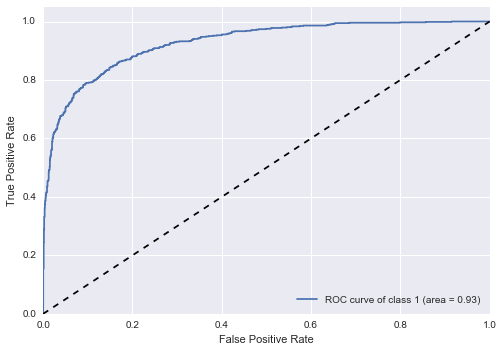


    Precision: 0.814
    Recall: 0.739
    F1: 0.775
    ROC: 0.928
    
time: 11.6 s


In [14]:
print('Eval on blocked')
_= eval_binary_classifier(b_model, b_test, calibration = False, roc = True)

Eval on random


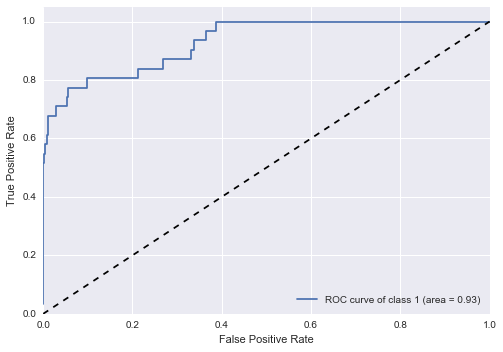


    Precision: 0.396
    Recall: 0.677
    F1: 0.500
    ROC: 0.930
    
time: 10.3 s


In [15]:
print('Eval on random')
_= eval_binary_classifier(b_model, r_test, calibration = False, roc = True)

### Train on random

In [16]:
r_model = optimal_pipeline.fit(r_train['x'], r_train['y'])

time: 36 s


Eval on blocked


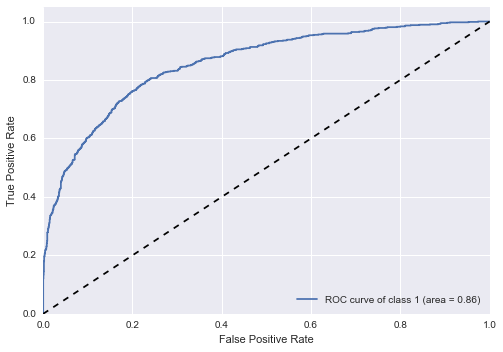


    Precision: 0.927
    Recall: 0.228
    F1: 0.366
    ROC: 0.857
    
time: 11.4 s


In [17]:
print('Eval on blocked')
_= eval_binary_classifier(r_model, b_test, calibration = False, roc = True)

Eval on random


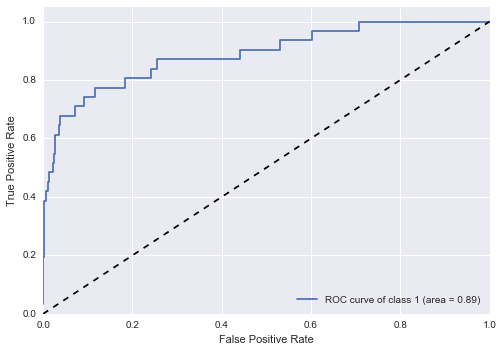


    Precision: 0.571
    Recall: 0.387
    F1: 0.462
    ROC: 0.889
    
time: 7.94 s


In [18]:
print('Eval on random')
_= eval_binary_classifier(r_model, r_test, calibration = False, roc = True)

### Train on both

In [19]:
br_model = optimal_pipeline.fit(br_train['x'], br_train['y'])

time: 1min 5s


Eval on blocked


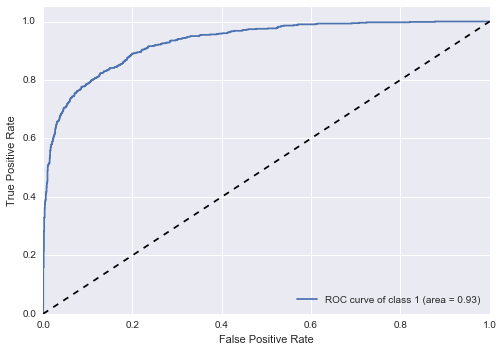


    Precision: 0.798
    Recall: 0.757
    F1: 0.777
    ROC: 0.931
    
time: 11.2 s


In [20]:
print('Eval on blocked')
_= eval_binary_classifier(br_model, b_test, calibration = False, roc = True)

Eval on random


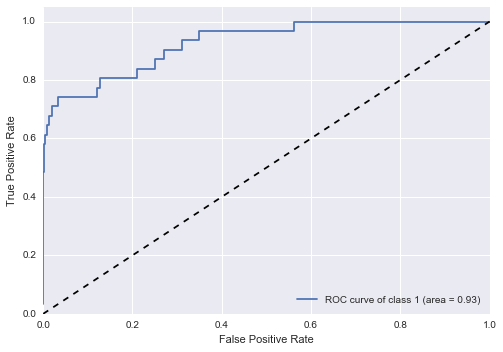


    Precision: 0.368
    Recall: 0.677
    F1: 0.477
    ROC: 0.926
    
time: 9.31 s


In [21]:
print('Eval on random')
_= eval_binary_classifier(br_model, r_test, calibration = False, roc = True)

Eval on both


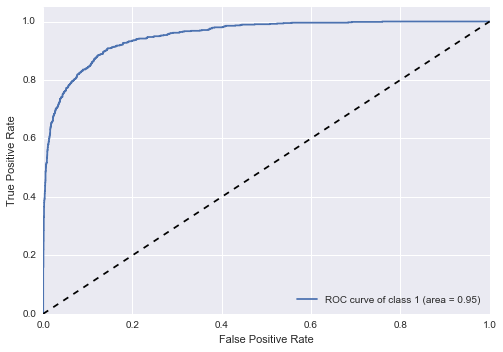


    Precision: 0.765
    Recall: 0.754
    F1: 0.759
    ROC: 0.952
    
time: 19.3 s


In [22]:
print('Eval on both')
_= eval_binary_classifier(br_model, br_test, calibration = False, roc = True)

### Check Calibration


    Precision: 0.765
    Recall: 0.754
    F1: 0.759
    ROC: 0.952
    


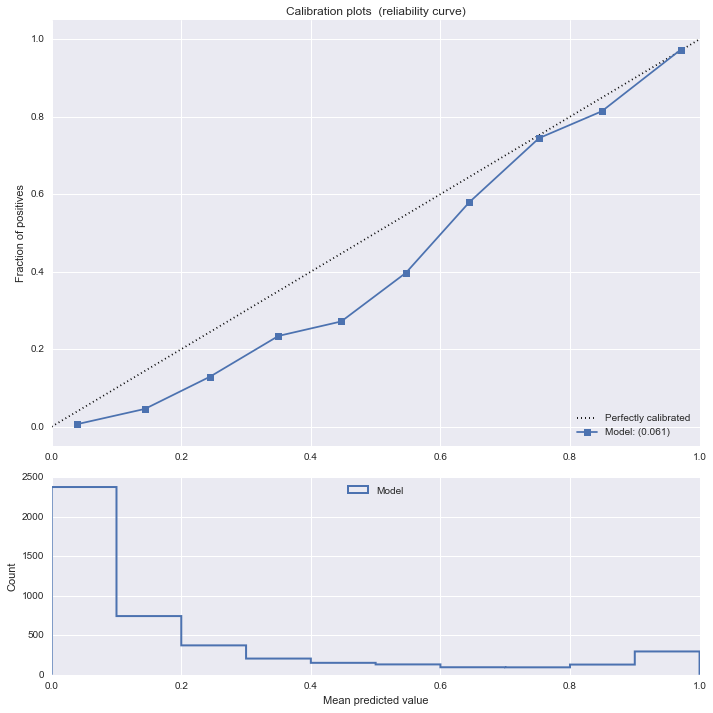

time: 20.3 s


In [23]:
_= eval_binary_classifier(br_model, br_test, calibration = True, roc = False)

### Error Analysis

In [24]:
fn, fp = get_clf_errors(br_model, br_test)

time: 19.5 s


In [25]:
# extreme False negatives
print_clf_errors(fn)

COMMENT:
This again shows that User Charles is stalking me. He keeps this user page in watchlist - and appears here less than two hours after I posted my complaint. If I had been stalking Charles in the start of this, I would have seen that he had approached Keilana with an accusation against me (and I would have had some possibility to answer before that questionable blocking made by Keilana). However, I do not stalk User Charles, contrary to what he is doing. I have been reading several times about Whi
SCORES: Actual: 1, Predicted: 0, Score: 0.03


COMMENT:
" Please do not vandalize pages, as you did with this edit to Brian. If you continue to do so, you will be blocked from editing.    01:41, 7 May 2009 (UTC)"
SCORES: Actual: 1, Predicted: 0, Score: 0.03


COMMENT:
They are all cunts It's not worth editing articles here concerning any serious issue. All sides consist of either people employed to edit or people with very strong opinions that will never, ever change. They advocate the

In [26]:
# extreme False positives
print_clf_errors(fp)

COMMENT:
Stf and don't say shit about me or to me you swedish piece of shit.  
SCORES: Actual: 0, Predicted: 1, Score: 0.99


COMMENT:
Are you a faggot or what?
SCORES: Actual: 0, Predicted: 1, Score: 0.99


COMMENT:
 I ALREADY ASKED YOU TO LEAVE ME ALONE IT IS APPARENT THAT I WAS RIGHT YOU SHITFACE LITTLE ASSWAD. CANT LEAVE WELL ENOUGH ALONE. GET THE FUCK AWAY FROM ME, I HAVE NO INTENTIONS OF EVER COMMENTING YOU AGAIN IF YOU JUST LEAVE ME ALONE!
SCORES: Actual: 0, Predicted: 1, Score: 0.98


COMMENT:
 Not a fan I don't like you one little bit.
SCORES: Actual: 0, Predicted: 1, Score: 0.96


COMMENT:
 Leftcoastman Proud of your block?  I guess being a liitle unemployed creep, you have little choice but to show off. And again, real evidence based edits are more important than civil POV bullshit. 166.205.138.250  
SCORES: Actual: 0, Predicted: 1, Score: 0.95


COMMENT:
 ...... You People Just Enjoy Picking on Me Don't You
SCORES: Actual: 0, Predicted: 1, Score: 0.92


COMMENT:
" Please RP

### Learning Curves!
Split blocked data into train and test. Train on a portion of train and test on test. This shows how well we do on blocked dat as we add more training data.

In [27]:
def get_roc(model, test):
    return roc_auc_score(test['y'], model.predict_proba(test['x'])[:, 1])

time: 1.41 ms


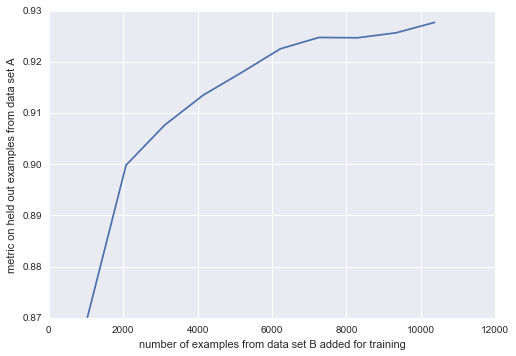

time: 5min 25s


In [28]:
ms, metrics = eval_adding_other_data(optimal_pipeline, None, b_test, b_train, get_roc, test_size = 0.5)
plot_adding_other_data(ms, metrics)

### How does adding blocked data change performance on random data?

Incrementally add blocked data to full random data set on training. Eval on held out blocked data.

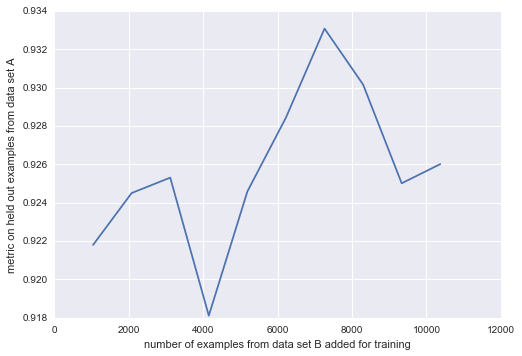

time: 36min 19s


In [29]:
ms, metrics = eval_adding_other_data(optimal_pipeline, r_train, r_test, b_train, get_roc, test_size = 0.8)
plot_adding_other_data(ms, metrics)

### How does adding random data change performance on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

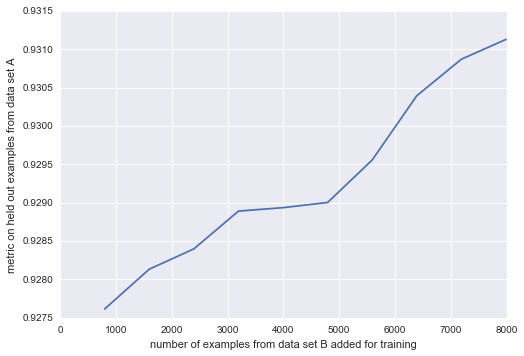

time: 12min 56s


In [30]:
ms, metrics = eval_adding_other_data(optimal_pipeline, b_train, b_test, r_train, get_roc, test_size = 0.8)
plot_adding_other_data(ms, metrics)

# Final Model

In [34]:
br_data = pd.concat([data_r,data_b])
final_model = optimal_pipeline.fit(br_data['x'], br_data['y'])
joblib.dump(final_model, '../../models/%s_ngram.pkl' % task)

['../../models/attack_ngram.pkl',
 '../../models/attack_ngram.pkl_01.npy',
 '../../models/attack_ngram.pkl_02.npy',
 '../../models/attack_ngram.pkl_03.npy',
 '../../models/attack_ngram.pkl_04.npy',
 '../../models/attack_ngram.pkl_05.npy',
 '../../models/attack_ngram.pkl_06.npy']

time: 2min 12s
